In [1]:
pip install transformers==4.55.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
Note: you

In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.WARNING)

In [ ]:
# !pip install -U "huggingface_hub[cli]"
!hf auth login --token 

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/vinum-qa-viwiki-model/vinum_QA_viwiki_model.csv")

# Filter rows where 'evidence' is NaN
na_samples = df[df['evidence'].isna()]

# Print how many there are
print(f"Number of rows with evidence == NaN: {len(na_samples)}\n")

# Display the first few examples
print(na_samples)


# EVAL TOP 1

Device: cuda
Loading tokenizer from HF repo: ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Loading sequence classification model from HF repo: ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc


config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

2025-11-12 13:24:56.148339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762953896.332844      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762953896.385268      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Loading test dataset from: /kaggle/input/predictions-vinum-sliding-window-top-1/predictions_vinum_sliding_window_top_1.csv


Evaluating Test Set: 100%|██████████| 126/126 [00:52<00:00,  2.39it/s]



Test Set Classification Report (verdict classifier):
              precision    recall  f1-score   support

     Support     0.8277    0.6597    0.7342       335
      Refute     0.7655    0.6627    0.7104       335
         NEI     0.6116    0.8179    0.6999       335

    accuracy                         0.7134      1005
   macro avg     0.7349    0.7134    0.7148      1005
weighted avg     0.7349    0.7134    0.7148      1005


Saved predictions to: /kaggle/working/test_with_predictions.csv

=== Retrieval / Verdict / Strict Summary ===
Total samples evaluated: 1005
ER correct: 572 / 1005  (ER acc = 0.5692)
VC correct: 717 / 1005  (VC acc = 0.7134)
Strict correct (both ER & VC): 503 / 1005  (Strict acc = 0.5005)
Saved confusion matrix to: /kaggle/working/confusion_matrix_counts.png


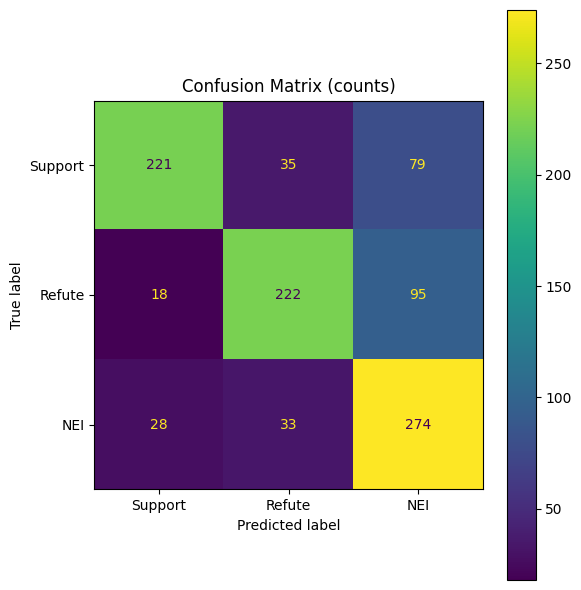

Done.


In [3]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Normalizer (your provided function)
# -----------------------------
def normalize_text(s):
    """Lower, strip, collapse whitespace, remove punctuation for EM/F1 normalization."""
    s = "" if s is None else s
    s = str(s).strip().lower()
    # Remove punctuation (same approach as many SQuAD eval scripts)
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

# -----------------------------
# Dataset class (same as training) with minor defensive coercion
# -----------------------------
class SentencePairDataset(Dataset):
    def __init__(self, sentence_pairs, labels, tokenizer, max_length):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, idx):
        sentence1, sentence2 = self.sentence_pairs[idx]
        label = self.labels[idx]

        # Defensive: coerce to str to avoid tokenizer TypeError
        s1 = "" if sentence1 is None else str(sentence1)
        s2 = "" if sentence2 is None else str(sentence2)

        encoding = self.tokenizer.encode_plus(
            s1,
            text_pair=s2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

# -----------------------------
# NOTE: We no longer need a custom classifier class here because we load
# AutoModelForSequenceClassification from the Hub (same architecture used in training).
# -----------------------------

# -----------------------------
# Load test data (KEEP null/empty predicted evidence — do NOT drop)
# -----------------------------
def load_test_data(test_path, tokenizer, max_length=512):
    """
    Returns:
      - dataset (SentencePairDataset) where sentence pair = (claim, predicted_evidence_or_empty_string)
      - predicted_evidences_raw: list (same order) of original predicted evidence values (may be NaN)
      - gold_evidences_raw: list of original gold evidence values (may be NaN)
      - gold_labels_int: list of gold labels as ints
    """
    valid_labels = {"Support", "Refute", "NEI"}
    label_mapping = {"Support": 0, "Refute": 1, "NEI": 2}

    df = pd.read_csv(test_path)

    # Keep only rows with valid gold_label values
    df = df[df["gold_label"].isin(valid_labels)].reset_index(drop=True)

    # Map labels (convert to ints)
    df["gold_label_int"] = df["gold_label"].map(label_mapping)

    # Keep predicted evidence even if NaN — but the dataset will feed an empty string to tokenizer for NaN.
    # We keep both "raw" lists (can contain NaN) and also the strings used as input to the classifier.
    predicted_evidences_raw = df["evidence"].tolist() if "evidence" in df.columns else [None] * len(df)
    gold_evidences_raw = df["gold_evidence"].tolist() if "gold_evidence" in df.columns else [None] * len(df)

    # Build sentence pairs (claim, predicted_evidence_for_tokenizer) where we coerce NaN -> ""
    pred_evidence_for_input = df["evidence"].fillna("").astype(str).tolist()
    claims_for_input = df["claim"].fillna("").astype(str).tolist()
    sentence_pairs = list(zip(claims_for_input, pred_evidence_for_input))

    labels = df["gold_label_int"].tolist()

    dataset = SentencePairDataset(sentence_pairs, labels, tokenizer, max_length)
    return dataset, predicted_evidences_raw, gold_evidences_raw, labels

# -----------------------------
# Evaluate function (returns predictions and true labels)
# -----------------------------
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(dataloader, desc="Evaluating Test Set"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # extract logits from ModelOutput
            logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
            _, predicted = torch.max(logits, dim=1)

        predictions.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

    print("\nTest Set Classification Report (verdict classifier):")
    print(classification_report(true_labels, predictions, digits=4, target_names=["Support","Refute","NEI"]))
    return true_labels, predictions

# -----------------------------
# Metrics: ER, VC, Strict
# -----------------------------
def compute_er_vc_strict(y_true, y_pred, pred_evidences_raw, gold_evidences_raw):
    """
    Args:
      - y_true, y_pred: lists of ints (same order)
      - pred_evidences_raw: list (may contain NaN or None) predicted evidence strings
      - gold_evidences_raw: list (may contain NaN or None) gold evidence strings

    Behavior:
      - Normalizes text using normalize_text and compares for exact equality.
      - If predicted evidence is missing/empty and gold evidence is non-empty -> ER is considered incorrect.
      - If both predicted and gold are empty -> ER considered correct (they match after normalization).
    """
    N = len(y_true)
    assert N == len(y_pred) == len(pred_evidences_raw) == len(gold_evidences_raw)
    er_flags = []
    vc_flags = []
    strict_flags = []

    for i in range(N):
        pred_raw = pred_evidences_raw[i]
        gold_raw = gold_evidences_raw[i]

        # Detect null/empty in original columns
        pred_is_null = pd.isna(pred_raw) or str(pred_raw).strip() == "" or str(pred_raw).lower().strip() == "nan"

        # Normalized strings (coerce None->"")
        pred_norm = normalize_text("" if pred_raw is None or (isinstance(pred_raw, float) and np.isnan(pred_raw)) else pred_raw)
        gold_norm = normalize_text("" if gold_raw is None or (isinstance(gold_raw, float) and np.isnan(gold_raw)) else gold_raw)

        # ER correctness logic:
        # - if predicted is empty but gold is non-empty => incorrect (explicit requirement)
        # - else check normalized exact match
        if pred_is_null:
            er_correct = False
        else:
            er_correct = (pred_norm == gold_norm)

        vc_correct = (y_pred[i] == y_true[i])
        strict_correct = er_correct and vc_correct

        er_flags.append(er_correct)
        vc_flags.append(vc_correct)
        strict_flags.append(strict_correct)

    er_count = sum(er_flags)
    vc_count = sum(vc_flags)
    strict_count = sum(strict_flags)

    results = {
        "n": N,
        "er_count": er_count,
        "vc_count": vc_count,
        "strict_count": strict_count,
        "er_acc": er_count / N if N else 0.0,
        "vc_acc": vc_count / N if N else 0.0,
        "strict_acc": strict_count / N if N else 0.0,
        "er_flags": er_flags,
        "vc_flags": vc_flags,
        "strict_flags": strict_flags
    }
    return results

# -----------------------------
# Confusion matrix plotting helper (raw counts)
# -----------------------------
def plot_confusion_matrix_counts(y_true,
                                 y_pred,
                                 labels=None,
                                 figsize=(6,6),
                                 save_path=None):
    cm = confusion_matrix(y_true, y_pred)  # integer counts
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, values_format='d')
    ax.set_title("Confusion Matrix (counts)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved confusion matrix to: {save_path}")
    plt.show()

# -----------------------------
# MAIN: Load + Test + Compute ER/VC/Strict + Plot CM
# -----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    TEST_PATH = "/kaggle/input/predictions-vinum-sliding-window-top-1/predictions_vinum_sliding_window_top_1.csv"

    # Config
    MAX_LENGTH = 512
    BATCH_SIZE = 8
    CM_SAVE_PATH = "/kaggle/working/confusion_matrix_counts.png"   # set to None if you don't want to save
    LABEL_NAMES = ["Support", "Refute", "NEI"]

    # -----------------------------
    # LOAD TOKENIZER + MODEL FROM HF repo (AutoModelForSequenceClassification)
    # -----------------------------
    HF_REPO_ID = "ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc"   # public repo on HF containing tokenizer & model

    # Load tokenizer from Hub
    print("Loading tokenizer from HF repo:", HF_REPO_ID)
    tokenizer = AutoTokenizer.from_pretrained(HF_REPO_ID)

    # Load full sequence classification model from Hub
    print("Loading sequence classification model from HF repo:", HF_REPO_ID)
    model = AutoModelForSequenceClassification.from_pretrained(HF_REPO_ID)
    model.to(device)

    # Load test dataset + dataloader (KEEP rows with null predicted evidence)
    print("Loading test dataset from:", TEST_PATH)
    test_dataset, pred_evidences_raw, gold_evidences_raw, gold_labels_int = load_test_data(TEST_PATH, tokenizer, max_length=MAX_LENGTH)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Run evaluation (verdict classifier)
    y_true, y_pred = evaluate(model, test_loader, device)

    # After running evaluation and getting y_pred
    label_id2name = {0: "Support", 1: "Refute", 2: "NEI"}
    
    # Load original CSV again (to keep same order and all columns)
    df_test = pd.read_csv(TEST_PATH)
    
    # Map predicted IDs back to label names
    pred_labels = [label_id2name[i] for i in y_pred]
    
    # Attach to the same filtered dataframe used in evaluation
    df_filtered = df_test[df_test["gold_label"].isin(["Support", "Refute", "NEI"])].reset_index(drop=True)
    df_filtered["pred_label"] = pred_labels
    
    # Save as new CSV
    SAVE_PATH = "/kaggle/working/test_with_predictions.csv"
    df_filtered.to_csv(SAVE_PATH, index=False)
    print(f"\nSaved predictions to: {SAVE_PATH}")

    # Compute ER / VC / Strict
    metrics = compute_er_vc_strict(y_true, y_pred, pred_evidences_raw, gold_evidences_raw)
    print("\n=== Retrieval / Verdict / Strict Summary ===")
    print(f"Total samples evaluated: {metrics['n']}")
    print(f"ER correct: {metrics['er_count']} / {metrics['n']}  (ER acc = {metrics['er_acc']:.4f})")
    print(f"VC correct: {metrics['vc_count']} / {metrics['n']}  (VC acc = {metrics['vc_acc']:.4f})")
    print(f"Strict correct (both ER & VC): {metrics['strict_count']} / {metrics['n']}  (Strict acc = {metrics['strict_acc']:.4f})")

    # Plot confusion matrix with raw counts (no normalization, integer display)
    if len(y_true) == 0 or len(y_pred) == 0:
        print("No predictions/labels to build confusion matrix.")
    else:
        plot_confusion_matrix_counts(y_true, y_pred, labels=LABEL_NAMES, figsize=(6,6), save_path=CM_SAVE_PATH)

    print("Done.")


In [ ]:
# -----------------------------
# Line-by-line display of incorrect label predictions
# -----------------------------
def print_incorrect_label_predictions_linewise(df, y_true, y_pred, label_names):
    wrong_idx = [i for i in range(len(y_true)) if y_pred[i] != y_true[i]]
    print(f"\n=== Incorrect Label Predictions (VC mismatches) ===")
    print(f"Total incorrect verdicts: {len(wrong_idx)} / {len(y_true)}\n")

    if not wrong_idx:
        print("✅ All verdicts predicted correctly!")
        return
    temp = wrong_idx[:10]
    for i in temp:
        claim = str(df.loc[i, "claim"]).strip()
        evidence = str(df.loc[i, "evidence"]).strip() if "evidence" in df.columns else ""
        gold = label_names[y_true[i]]
        pred = label_names[y_pred[i]]

        print(f"[{i}]")
        print(f"Claim: {claim}")
        print(f"Evidence: {evidence}")
        print(f"Gold: {gold}")
        print(f"Pred: {pred}")
        print("-" * 80)  # separator

# Usage:
test_df = pd.read_csv(TEST_PATH)
print_incorrect_label_predictions_linewise(test_df, y_true, y_pred, LABEL_NAMES)


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/viwiki-top1-bi-encoder-with-evidence/viwiki-top1-bi-encoder-with-evidence.csv")

# Filter rows where 'evidence' is NaN
na_samples = df[df['evidence'].isna()]

# Print how many there are
print(f"Number of rows with evidence == NaN: {len(na_samples)}\n")

# Display the first few examples
print(na_samples)


# EVAL TOP K

In [ ]:
import os
import re
import ast
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# -----------------------------
# CONFIG / PATHS
# -----------------------------
INPUT_CSV = "/kaggle/input/predictions-viwiki-cafebert-qa-topk/predictions_viwiki_CafeBert_QA_topk.csv"
OUT_CSV = "predictions_with_pair_labels_top10.csv"
HF_REPO_ID = "ICTuniverse/CafeBERT-FC-one-shot-viwiki"  
BATCH_SIZE = 32
MAX_LENGTH = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# label mapping used by the model (adjust if your classifier uses different mapping)
INT2LABEL = {0: "Support", 1: "Refute", 2: "NEI"}

# -----------------------------
# Dataset for (claim, evidence) pairs
# -----------------------------
class SentencePairDataset(Dataset):
    def __init__(self, sentence_pairs, tokenizer, max_length=256):
        self.sentence_pairs = sentence_pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, idx):
        s1, s2 = self.sentence_pairs[idx]
        s1 = "" if s1 is None else str(s1)
        s2 = "" if s2 is None else str(s2)
        encoding = self.tokenizer.encode_plus(
            s1,
            text_pair=s2,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# -----------------------------
# Load model & tokenizer
# -----------------------------
print("Loading tokenizer and model from:", HF_REPO_ID)
tokenizer = AutoTokenizer.from_pretrained(HF_REPO_ID)
model = AutoModelForSequenceClassification.from_pretrained(HF_REPO_ID)
model.to(device)
model.eval()

# -----------------------------
# Read input file and expand pairs
# -----------------------------
df = pd.read_csv(INPUT_CSV)
required = {"claim", "question", "cid", "evidence", "gold_evidence", "gold_label"}
if not required.issubset(set(df.columns)):
    raise ValueError(f"Input CSV must contain columns: {required}. Found: {df.columns.tolist()}")

# Parse evidence column which may be stringified lists
def parse_evidence_cell(x):
    if pd.isna(x):
        return [""]
    if isinstance(x, list):
        return [("" if (e is None or (isinstance(e, float) and pd.isna(e))) else str(e)) for e in x]
    if isinstance(x, str):
        x = x.strip()
        # Try to parse as Python literal list first
        if (x.startswith("[") and x.endswith("]")) or (x.startswith("(") and x.endswith(")")):
            try:
                parsed = ast.literal_eval(x)
                if isinstance(parsed, (list, tuple)):
                    return [("" if (e is None or (isinstance(e, float) and pd.isna(e))) else str(e)) for e in parsed]
            except Exception:
                pass
        # fallback: treat as comma-separated string
        parts = [p.strip() for p in x.split(",") if p.strip() != ""]
        if parts:
            return parts
        # if non-empty single string that is not a list, return it as single evidence
        if x != "":
            return [x]
        return [""]
    # other types -> stringify
    return [str(x)]

all_pairs = []         # list of (claim, evidence) pairs for model input
row_map = []           # for each pair, which original row index it belongs to
cid_map = []           # store corresponding cid (for alignment)
evidence_raw_map = []  # store original evidence text for that pair (string)

for idx, row in df.iterrows():
    claim = row["claim"]
    raw_cids = row["cid"]
    # cid may be a single string like "778,261,387" or list. normalize to list of cid tokens (strings)
    if pd.isna(raw_cids):
        cid_tokens = [""]
    elif isinstance(raw_cids, list):
        cid_tokens = [str(x) for x in raw_cids]
    else:
        # try to split by comma if it's a joined string
        s = str(raw_cids).strip()
        if (s.startswith("[") and s.endswith("]")):
            try:
                parsed = ast.literal_eval(s)
                cid_tokens = [str(x) for x in parsed]
            except Exception:
                cid_tokens = [p.strip() for p in s.split(",") if p.strip() != ""]
        else:
            cid_tokens = [p.strip() for p in s.split(",") if p.strip() != ""]

    evidences = parse_evidence_cell(row["evidence"])  # list of evidence strings
    # If number of evidences != number of cids, we still pair by position where possible.
    # We'll create pairs for each evidence item. Also attach matching cid if exists, else empty.
    for i, ev in enumerate(evidences):
        all_pairs.append((claim, ev))
        row_map.append(idx)
        # choose cid token at same index if available else empty
        cid_token = cid_tokens[i] if i < len(cid_tokens) else ""
        cid_map.append(cid_token)
        evidence_raw_map.append(ev)

# -----------------------------
# Run inference on all pairs in batches
# -----------------------------
dataset = SentencePairDataset(all_pairs, tokenizer, max_length=MAX_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

pred_labels_int = []
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Predicting pair labels"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
        preds = torch.argmax(logits, dim=1).cpu().tolist()
        pred_labels_int.extend(preds)

# Sanity check
if len(pred_labels_int) != len(all_pairs):
    raise RuntimeError("Prediction count mismatch: {} preds vs {} pairs".format(len(pred_labels_int), len(all_pairs)))

# -----------------------------
# Aggregate predicted labels back to original rows
# -----------------------------
# prepare a list-of-lists for predicted labels per original row index
preds_by_row = [[] for _ in range(len(df))]
for pair_idx, row_idx in enumerate(row_map):
    lab_int = pred_labels_int[pair_idx]
    lab_str = INT2LABEL.get(int(lab_int), str(lab_int))
    preds_by_row[row_idx].append(lab_str)

# create output dataframe: keep original columns and add pred_label column (stringified list)
out_df = df.copy()
out_df["pred_label"] = [preds_by_row[i] for i in range(len(out_df))]

# If you prefer to save pred_label as a string (CSV-friendly), convert lists to JSON-like strings
out_df["pred_label"] = out_df["pred_label"].apply(lambda lst: "[" + ", ".join(f"'{x}'" for x in lst) + "]")

# Save
out_df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print("Saved output to", OUT_CSV)


In [ ]:
temp = pd.read_csv("predictions_with_pair_labels_top10.csv")

In [ ]:
temp.iloc[2]['evidence'] 

In [ ]:
import pandas as pd
import ast
import re

# ---------- CONFIG ----------
INPUT_CSV = "predictions_with_pair_labels_top10.csv"

# ---------- helpers ----------
def safe_literal_eval(s):
    if pd.isna(s):
        return []
    if isinstance(s, list):
        return s
    if not isinstance(s, str):
        return [str(s)]
    s = s.strip()
    if s == "":
        return []
    try:
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple)):
            return list(val)
        return [val]
    except Exception:
        parts = [p.strip() for p in s.split(",") if p.strip() != ""]
        return parts if parts else [s]

def normalize_text(s):
    if s is None:
        s = ""
    s = str(s).strip().lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

# ---------- load ----------
df = pd.read_csv(INPUT_CSV)
for col in ("pred_label", "evidence", "gold_evidence", "gold_label"):
    if col not in df.columns:
        raise KeyError(f"Missing column: {col}")

# ---------- loop over top-K ----------
for TOP_K in range(1, 11):
    final_labels = []
    final_evidences = []
    vc_flags = []
    er_flags = []
    strict_flags = []

    for _, row in df.iterrows():
        pred_list = safe_literal_eval(row["pred_label"])
        evid_list = safe_literal_eval(row["evidence"])

        pred_list = [("" if (x is None) else str(x)) for x in pred_list]
        evid_list = [("" if (x is None or (isinstance(x, float) and pd.isna(x))) else str(x)) for x in evid_list]

        pred_trunc = pred_list[:TOP_K]
        evid_trunc = evid_list[:TOP_K]

        chosen_idx = None
        for i, lab in enumerate(pred_trunc):
            if str(lab).strip().upper() != "NEI":
                chosen_idx = i
                chosen_label = lab
                break

        if chosen_idx is None:
            final_label = "NEI"
            final_evidence = evid_trunc[0] if len(evid_trunc) > 0 else (evid_list[0] if len(evid_list) > 0 else "")
        else:
            final_label = str(chosen_label)
            final_evidence = evid_trunc[chosen_idx] if chosen_idx < len(evid_trunc) else ""

        final_labels.append(final_label)
        final_evidences.append(final_evidence)

        gold_label = "" if pd.isna(row.get("gold_label", "")) else str(row.get("gold_label", ""))
        vc = normalize_text(final_label) == normalize_text(gold_label)
        vc_flags.append(vc)

        gold_ev = "" if pd.isna(row.get("gold_evidence", "")) else str(row.get("gold_evidence", ""))
        er = normalize_text(final_evidence) == normalize_text(gold_ev)
        er_flags.append(er)

        strict_flags.append(vc and er)

    N = len(df)
    strict_count = sum(strict_flags)
    vc_count = sum(vc_flags)
    er_count = sum(er_flags)
    strict_acc = strict_count / N if N else 0.0
    vc_acc = vc_count / N if N else 0.0
    er_acc = er_count / N if N else 0.0

    print(f"TOP_K = {TOP_K}")
    print(f"Total samples: {N}")
    print(f"Verdict correct (VC): {vc_count} / {N}  (VC acc = {vc_acc:.4f})")
    print(f"Evidence correct (ER): {er_count} / {N}  (ER acc = {er_acc:.4f})")
    print(f"Strict correct (both VC & ER): {strict_count} / {N}  (Strict acc = {strict_acc:.4f})")
    print("=" * 22)


In [ ]:
import pandas as pd
import ast
import re
from sklearn.metrics import confusion_matrix, classification_report

# ---------- CONFIG ----------
INPUT_CSV = "predictions_with_pair_labels_top10.csv"

# ---------- helpers ----------
def safe_literal_eval(s):
    if pd.isna(s):
        return []
    if isinstance(s, list):
        return s
    if not isinstance(s, str):
        return [str(s)]
    s = s.strip()
    if s == "":
        return []
    try:
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple)):
            return list(val)
        return [val]
    except Exception:
        parts = [p.strip() for p in s.split(",") if p.strip() != ""]
        return parts if parts else [s]

def normalize_text(s):
    if s is None:
        s = ""
    s = str(s).strip().lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

# ---------- load ----------
df = pd.read_csv(INPUT_CSV)
for col in ("pred_label", "evidence", "gold_evidence", "gold_label"):
    if col not in df.columns:
        raise KeyError(f"Missing column: {col}")

# ---------- loop over top-K ----------
for TOP_K in range(1, 11):
    final_labels = []
    final_evidences = []
    vc_flags = []
    er_flags = []
    strict_flags = []
    gold_labels_clean = []

    for _, row in df.iterrows():
        pred_list = safe_literal_eval(row["pred_label"])
        evid_list = safe_literal_eval(row["evidence"])

        pred_list = [("" if (x is None) else str(x)) for x in pred_list]
        evid_list = [("" if (x is None or (isinstance(x, float) and pd.isna(x))) else str(x)) for x in evid_list]

        pred_trunc = pred_list[:TOP_K]
        evid_trunc = evid_list[:TOP_K]

        chosen_idx = None
        for i, lab in enumerate(pred_trunc):
            if str(lab).strip().upper() != "NEI":
                chosen_idx = i
                chosen_label = lab
                break

        if chosen_idx is None:
            final_label = "NEI"
            final_evidence = evid_trunc[0] if len(evid_trunc) > 0 else (evid_list[0] if len(evid_list) > 0 else "")
        else:
            final_label = str(chosen_label)
            final_evidence = evid_trunc[chosen_idx] if chosen_idx < len(evid_trunc) else ""

        final_labels.append(final_label)
        final_evidences.append(final_evidence)

        gold_label = "" if pd.isna(row.get("gold_label", "")) else str(row.get("gold_label", ""))
        gold_labels_clean.append(gold_label)

        vc = normalize_text(final_label) == normalize_text(gold_label)
        vc_flags.append(vc)

        gold_ev = "" if pd.isna(row.get("gold_evidence", "")) else str(row.get("gold_evidence", ""))
        er = normalize_text(final_evidence) == normalize_text(gold_ev)
        er_flags.append(er)

        strict_flags.append(vc and er)

    # ---------- compute metrics ----------
    N = len(df)
    strict_count = sum(strict_flags)
    vc_count = sum(vc_flags)
    er_count = sum(er_flags)
    strict_acc = strict_count / N if N else 0.0
    vc_acc = vc_count / N if N else 0.0
    er_acc = er_count / N if N else 0.0

    print(f"\nTOP_K = {TOP_K}")
    print(f"Total samples: {N}")
    print(f"Verdict correct (VC): {vc_count} / {N}  (VC acc = {vc_acc:.4f})")
    print(f"Evidence correct (ER): {er_count} / {N}  (ER acc = {er_acc:.4f})")
    print(f"Strict correct (both VC & ER): {strict_count} / {N}  (Strict acc = {strict_acc:.4f})")

    # ---------- confusion matrix ----------
    y_true = [normalize_text(x) for x in gold_labels_clean]
    y_pred = [normalize_text(x) for x in final_labels]
    labels_order = ["support", "refute", "nei"]

    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=[f"T_{l}" for l in labels_order],
                          columns=[f"P_{l}" for l in labels_order]))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=labels_order, digits=4))
    print("=" * 40)


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/kaggle/input/predictions-viwiki-xlm-oneshot-top10/predictions_viwiki_XLM_oneshot_top10.csv")

# Filter rows where 'evidence' is NaN
na_samples = df[df['evidence'].isna()]

# Print how many there are
print(f"Number of rows with evidence == NaN: {len(na_samples)}\n")

# Display the first few examples
print(na_samples)


In [ ]:
temp.iloc[175]